In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [29]:
'''1、生成一个长度为m的列向量矩阵（m为两类两本的总个数）
   2、这一整个向量中，例如，属于class1的，那该值就为1，不属于就为0
   3、返回一个指示向量'''
def createDirectionVector(class_1_len,class_2_len):
    v1_ones = np.ones((class_1_len))
    v1_zeros = np.zeros((class_1_len))
    v2_ones = np.ones((class_2_len))
    v2_zeros = np.zeros((class_2_len))
    dv_1 = np.concatenate((v1_ones,v2_zeros), axis=0)
    dv_2 = np.concatenate((v1_zeros,v2_ones), axis=0)
    return np.mat(dv_1).T,np.mat(dv_2).T
#createDirectionVector(class_1.shape[0],class_2.shape[0])

In [30]:
'''1、核函数的选择'''
def selectKernelFunction(kernel):
    if kernel == 0:
        #线性核
        linear = lambda x_i,x_j,x: np.dot(x_i, x_j.T)
        return linear
    if kernel == 1:
        #高斯核
        rbf = lambda x_i,x_j,gamma: np.exp(-np.dot((x_i-x_j),(x_i-x_j).T) / (2*gamma*gamma))
        return rbf
    if kernel == 2:
        #拉普拉斯核
        lp = lambda x_i,x_j,gamma:np.exp(-(np.dot((x_i-x_j),(x_i-x_j).T))**.5 / gamma)
        return lp

In [31]:
'''1、计算核函数的核矩阵
   2、选择相应的核函数
   3、输入两个类的样本矩阵
   4、gamma高斯核的带宽,暂时默认为1/n_feature'''
def calcuKernelMatrix(kernel, class_1, class_2):
    gamma = 1.0 / class_1.shape[1]
    class_all = np.concatenate((class_1, class_2), axis=0)
    class_all_rows = class_all.shape[0]
    k_matrix = np.zeros((class_all_rows, class_all_rows))
    kernel_func = selectKernelFunction(kernel)
    for i in range(class_all_rows):
        for j in range(class_all_rows):
            k_matrix[i][j] = kernel_func(class_all[i], class_all[j], 20)
    return k_matrix
#calcuKernelMatrix(1,class_1,class_2)   

In [32]:
'''1、计算经过高维映射后的类中心
   2、返回的是特征空间中的类中心向量'''
def calcuClassCenter(class_len, direction_vector, k_matrix):    
    center = 1.0*np.dot(k_matrix, direction_vector) / class_len
    return center

#calcuClassCenter(class_1.shape[0], c[0], k).shape

In [33]:
def SVD(matrix):
    u,s,v = np.linalg.svd(matrix)    
    s = np.mat(np.diag(s))
    u = np.mat(u)
    v = np.mat(v)
    reverse = np.dot(np.dot(v.T,s.I),u.T)
    return reverse

In [34]:
'''1、在特征空间中的类内散度矩阵的逆矩阵'''
def calcuInternalClassScatter(kernel,class_1, class_2):
    class_1_len = class_1.shape[0]
    class_2_len = class_2.shape[0]
    #生成指示向量
    direction_vector_1,direction_vector_2 = createDirectionVector(class_1_len,class_2_len)
    #获取核函数矩阵
    k_matrix = calcuKernelMatrix(kernel, class_1, class_2)
    #计算特征空间中的类中心
    center_1 = calcuClassCenter(class_1_len, direction_vector_1, k_matrix)
    center_2 = calcuClassCenter(class_2_len, direction_vector_2, k_matrix)
    #计算特征空间中的类内散度矩阵
    u = class_1_len * np.dot(direction_vector_1,direction_vector_1.T) + class_2_len * np.dot(direction_vector_2,direction_vector_2.T) 
    ics = np.dot(k_matrix, k_matrix.T) - u
    ics_reverse = SVD(ics)
    return ics_reverse

#calcuInternalClassScatter(1, class_1, class_2)

In [35]:
'''1、计算投影函数的系数
   2、返回向量矩阵'''
def getCoefficient(kernel,class_1, class_2):
    class_1_len = class_1.shape[0]
    class_2_len = class_2.shape[0]
    #计算两个类中心在特征空间上的差值
    direction_vector_1,direction_vector_2 = createDirectionVector(class_1_len,class_2_len)
    diff = (direction_vector_1 - direction_vector_2)
    #获取特征空间中的类内散度矩阵
    ics_reverse = calcuInternalClassScatter(kernel,class_1, class_2)
    #计算投影函数的系数
    cf = np.dot(ics_reverse,diff)
    return cf
#getCoefficient(1, class_1, class_2).shape

In [36]:
def calcuProjectionValue(kernel, class_1, class_2, one_sample):
    samples = np.concatenate((class_1,class_2))
    #获得投影系数
    cf = getCoefficient(kernel,class_1, class_2)
    #计算指定样本点与所有样本的核函数值
    kernel_value = np.dot(samples,one_sample.T)
    #计算投影值
    m_projection = np.array(cf)*np.array(kernel_value)
    projection_value = m_projection.T[0].sum()
    return projection_value

#calcuProjectionValue(1, class_1, class_2, np.mat(class_1[0]))

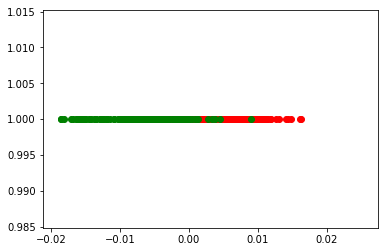

In [37]:
if 1==1:
    #points = pd.read_csv('../data/西瓜数据集3.0')
    points = pd.read_csv('../data/testdata')
    data = np.array(points.ix[:,:2])
    labels = np.array(points.ix[:,2])
    class_1 = data[labels == 0]
    class_2 = data[labels ==1]
    projection_1 = []
    projection_2 = []
    for sample in class_1:
        projection_1.append(calcuProjectionValue(1, class_1, class_2, sample))
    
    for sample in class_2:
        projection_2.append(calcuProjectionValue(1, class_1, class_2, sample))
    plt.figure()
    plt.scatter(projection_1, np.ones(len(projection_1)), c='red')
    plt.scatter(projection_2, np.ones(len(projection_2)), c='green')